In [11]:
import pandas as pd
import datetime
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pickle
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [12]:
pd.set_option('display.max_colwidth', None)

# Load the data file
data_file = 'fraudTrain.csv'
df = pd.read_csv(data_file, dtype=str)

df.head()

,ID,Time,Card Number,merchant,category,Amount,firstName,lastName,trans_num,is_fraud
0,0,1/1/2019 12:00:00 AM,2.70E+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,0b242abb623afc578575680df30655b9,0
1,1,1/1/2019 12:00:00 AM,6.30E+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,1f76529f8574734946361c461b024d99,0
2,2,1/1/2019 12:00:00 AM,3.89E+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,a1a22d70485983eac12b5b88dad1cf95,0
3,3,1/1/2019 12:01:00 AM,3.53E+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45,Jeremy,White,6b849c168bdad6f867558c3793159a81,0
4,4,1/1/2019 12:03:00 AM,3.76E+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,a41d7549acf90789359a9aa5346dcb46,0


In [13]:
num_duplicates = df.duplicated().sum()

# Print the number of duplicates
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [14]:
#Print the number of empty cells
missing_values = df.isnull().sum()

print("Missing values per column:")
print(missing_values)

df = df.dropna(subset=['firstName', 'lastName'])
missing_values = df.isnull().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
ID             0
Time           0
Card Number    0
merchant       0
category       0
Amount         1
firstName      1
lastName       1
trans_num      1
is_fraud       1
dtype: int64
Missing values per column:
ID             0
Time           0
Card Number    0
merchant       0
category       0
Amount         0
firstName      0
lastName       0
trans_num      0
is_fraud       0
dtype: int64


In [15]:
column_types = df.dtypes

print(column_types)

ID             object
Time           object
Card Number    object
merchant       object
category       object
Amount         object
firstName      object
lastName       object
trans_num      object
is_fraud       object
dtype: object


In [16]:
#Processing "Time" Column

df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y %I:%M:%S %p')

# Extract the day of the week and save it in a new column "Weekday"
df['Weekday'] = df['Time'].dt.strftime('%A')

# Define the function to check time of day
def check_time_of_day(timestamp):
    time_obj = timestamp.time()
    morning_start = datetime.time(6, 0)   
    afternoon_start = datetime.time(12, 0) 
    evening_start = datetime.time(18, 0)   
    night_start = datetime.time(22, 0)     
    if time_obj >= morning_start and time_obj < afternoon_start:
        return "Morning"
    elif time_obj >= afternoon_start and time_obj < evening_start:
        return "Afternoon"
    elif time_obj >= evening_start and time_obj < night_start:
        return "Evening"
    else:
        return "Night"

    
# Apply the function to the "Time" column and create a new column with the result
df['Time of Day'] = df['Time'].apply(check_time_of_day)

df['Month'] = df['Time'].dt.month
df['Year'] = df['Time'].dt.year

df.head()


,ID,Time,Card Number,merchant,category,Amount,firstName,lastName,trans_num,is_fraud,Weekday,Time of Day,Month,Year
0,0,2019-01-01 00:00:00,2.70E+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,0b242abb623afc578575680df30655b9,0,Tuesday,Night,1,2019
1,1,2019-01-01 00:00:00,6.30E+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,1f76529f8574734946361c461b024d99,0,Tuesday,Night,1,2019
2,2,2019-01-01 00:00:00,3.89E+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,a1a22d70485983eac12b5b88dad1cf95,0,Tuesday,Night,1,2019
3,3,2019-01-01 00:01:00,3.53E+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45,Jeremy,White,6b849c168bdad6f867558c3793159a81,0,Tuesday,Night,1,2019
4,4,2019-01-01 00:03:00,3.76E+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,a41d7549acf90789359a9aa5346dcb46,0,Tuesday,Night,1,2019


In [17]:
y = np.array(df['is_fraud'])
print(y)

df = df.drop(columns=['ID', 'Time', 'trans_num', 'is_fraud', 'firstName', 'lastName', 'lastName', 'firstName', 'Card Number'])
df.head()

['0' '0' '0' ... '0' '0' '0']


,merchant,category,Amount,Weekday,Time of Day,Month,Year
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Tuesday,Night,1,2019
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Tuesday,Night,1,2019
2,fraud_Lind-Buckridge,entertainment,220.11,Tuesday,Night,1,2019
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45,Tuesday,Night,1,2019
4,fraud_Keeling-Crist,misc_pos,41.96,Tuesday,Night,1,2019


In [26]:
# Create MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the data
df['Amount'] = scaler.fit_transform(df[['Amount']])
with open('scaler.sav', 'wb') as file:
    pickle.dump(scaler, file)
df.head()

,merchant,category,Amount,Weekday,Time of Day,Month,Year
0,"fraud_Rippin, Kub and Mann",misc_net,0.000137,Tuesday,Night,1,2019
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,0.003670,Tuesday,Night,1,2019
2,fraud_Lind-Buckridge,entertainment,0.007569,Tuesday,Night,1,2019
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,0.001520,Tuesday,Night,1,2019
4,fraud_Keeling-Crist,misc_pos,0.001415,Tuesday,Night,1,2019


In [19]:
# Define the list of categorical columns
categorical_columns = ['merchant', 'category', 'Weekday', 'Time of Day', 'Month', 'Year']

# Loop through each categorical column and perform the chi-squared test
for column in categorical_columns:
    # Construct contingency table from categorical column and target variable
    contingency_table = pd.crosstab(index=df[column], columns=y)
    
    # Perform chi-squared test
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    
    # Print results
    print("Chi-squared statistic for", column, ":", chi2_stat)
    print("P-value for", column, ":", p_val)
    print("=========================")

Chi-squared statistic for merchant : 5487.894571646156
P-value for merchant : 0.0
Chi-squared statistic for category : 4976.31200777629
P-value for category : 0.0
Chi-squared statistic for Weekday : 113.26520844315155
P-value for Weekday : 4.2190018507508895e-22
Chi-squared statistic for Time of Day : 8662.633805086545
P-value for Time of Day : 0.0
Chi-squared statistic for Month : 449.4459078119635
P-value for Month : 1.8895690921016518e-89
Chi-squared statistic for Year : 6.711130871946504
P-value for Year : 0.009581294439831524


In [27]:
categorical_columns = ['merchant', 'category', 'Time of Day']

# Extract categorical columns and convert them to a separate DataFrame
df_categorical = df[categorical_columns]

# One-hot encode categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(df_categorical)

# Convert encoded features to DataFrame
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
with open('encoder.sav', 'wb') as file:
    pickle.dump(encoder, file)
X_encoded_df.head()

,merchant_fraud_Abbott-Rogahn,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,"merchant_fraud_Altenwerth, Cartwright and Koss",merchant_fraud_Altenwerth-Kilback,merchant_fraud_Ankunding LLC,merchant_fraud_Ankunding-Carroll,...,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
X_train= X_encoded_df
X_train["Amount"]=df["Amount"]
X_train.head()

,merchant_fraud_Abbott-Rogahn,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,"merchant_fraud_Altenwerth, Cartwright and Koss",merchant_fraud_Altenwerth-Kilback,merchant_fraud_Ankunding LLC,merchant_fraud_Ankunding-Carroll,...,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Amount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000137
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.003670
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.007569
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001520
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001415


In [38]:
data_file = 'fraudTest.csv'
x_test = pd.read_csv(data_file, dtype=str)
x_test.head()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 16: invalid start byte

In [28]:

#Processing Time
x_test['Time'] = pd.to_datetime(x_test['Time'], format='%m/%d/%Y %I:%M:%S %p')
x_test['Time of Day'] = x_test['Time'].apply(check_time_of_day)


x_test.head()

NameError: name 'x_test' is not defined

In [ ]:
y_test = np.array(x_test['is_fraud'])
print(y_test)

x_test = x_test.drop(columns=['ID', 'Time', 'trans_num', 'is_fraud', 'firstName', 'lastName', 'Card Number'])
x_test.head()

['0' '0' '0' ... '0' '0' '0']


,merchant,category,Amount,Time of Day
0,fraud_Kirlin and Sons,personal_care,2.86,Afternoon
1,fraud_Sporer-Keebler,personal_care,29.84,Afternoon
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Afternoon
3,fraud_Haley Group,misc_pos,60.05,Afternoon
4,fraud_Johnston-Casper,travel,3.19,Afternoon


In [ ]:
# Fit and transform the data
x_test['Amount'] = scaler.transform(x_test[['Amount']])
x_test.head()

,merchant,category,Amount,Time of Day
0,fraud_Kirlin and Sons,personal_care,0.000064,Afternoon
1,fraud_Sporer-Keebler,personal_care,0.000996,Afternoon
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,0.001391,Afternoon
3,fraud_Haley Group,misc_pos,0.002040,Afternoon
4,fraud_Johnston-Casper,travel,0.000076,Afternoon


In [ ]:
categorical_columns = ['merchant', 'category', 'Time of Day']

# Extract categorical columns and convert them to a separate DataFrame
x_test_categorical = x_test[categorical_columns]

X_encoded = encoder.transform(x_test_categorical)

# Convert encoded features to DataFrame
X_test = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
X_test.head()

,merchant_fraud_Abbott-Rogahn,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,"merchant_fraud_Altenwerth, Cartwright and Koss",merchant_fraud_Altenwerth-Kilback,merchant_fraud_Ankunding LLC,merchant_fraud_Ankunding-Carroll,...,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
X_test["Amount"]=x_test["Amount"]
X_test.head()

,merchant_fraud_Abbott-Rogahn,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,"merchant_fraud_Altenwerth, Cartwright and Koss",merchant_fraud_Altenwerth-Kilback,merchant_fraud_Ankunding LLC,merchant_fraud_Ankunding-Carroll,...,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Amount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000064
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000996
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.001391
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.002040
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.000076


In [ ]:
def load_and_evaluate(filename, numerical, x_test, y_test):
    model = pickle.load(open(filename, 'rb'))

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    if numerical:
        fraud = sum(1 for pred in y_pred if pred == 1)
        not_fraud = sum(1 for pred in y_pred if pred == 0)
    else:
        fraud = sum(1 for pred in y_pred if pred == '1')
        not_fraud = sum(1 for pred in y_pred if pred == '0')
    
    # Plot a heatmap of the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.text(2, 0.5, f'Accuracy: {accuracy:.5f}\nPrecision: {precision:.5f}\nRecall: {recall:.5f}\nF1-score: {f1:.5f}\nPredicted Fraud cases: {fraud}\nPredicted Not Fraud cases: {not_fraud}', horizontalalignment='right', verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)
    plt.show()

In [ ]:
def save(filename, model):
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y)

y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))



save('logistic_model.sav')

print('Saved model successfully')
print('========================')

Accuracy: 0.9959961779244546
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

Saved model successfully


Accuracy: 0.9959961779244546


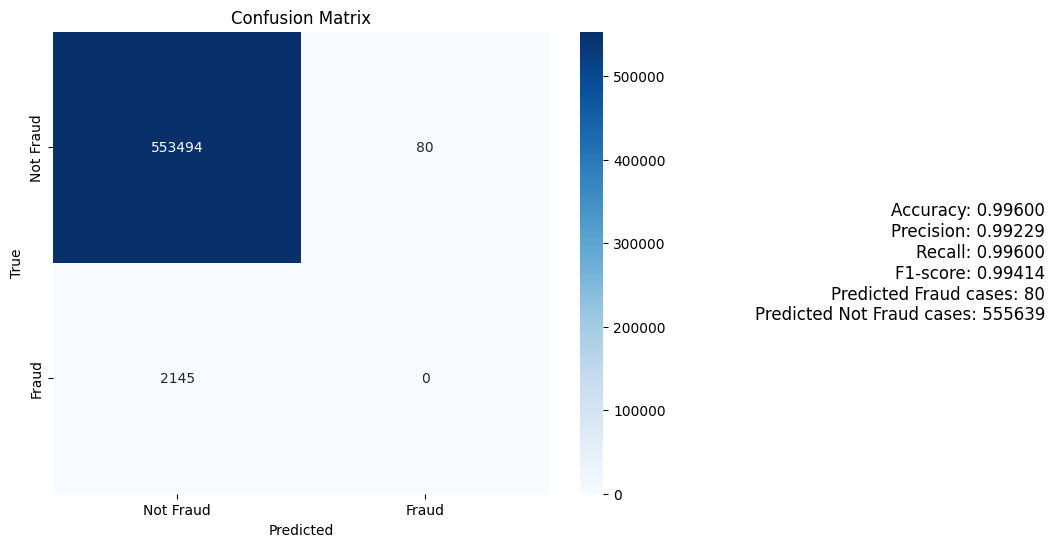

In [ ]:
load_and_evaluate('logistic_model.sav', False, X_test, y_test)

In [ ]:
y_binary = np.array(y, dtype=int)

model_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model_xgb.fit(X_train, y_binary)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred = model_xgb.predict(X_test)

y_test_binary = np.array(y_test, dtype=int)

# Evaluate the model
accuracy = accuracy_score(y_test_binary, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_binary, y_pred))

save('xgb_model.sav', model_xgb)

print('Saved model successfully')
print('========================')

Accuracy: 0.9976894797550561
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.71      0.67      0.69      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.84      0.85    555719
weighted avg       1.00      1.00      1.00    555719

Saved model successfully


Accuracy: 0.9976894797550561


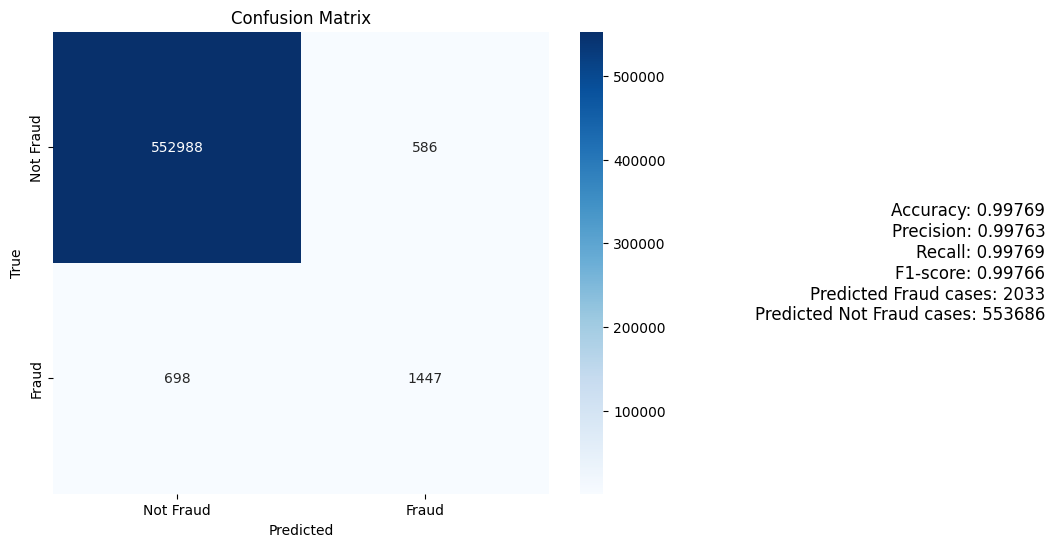

In [ ]:
load_and_evaluate('xgb_model.sav', True, X_test, np.array(y_test, dtype=int))

In [ ]:
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

save('DT_model.sav', clf)

print('Saved model successfully')
print('========================')

Accuracy: 0.9969067100459045
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.59      0.65      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.83      0.81    555719
weighted avg       1.00      1.00      1.00    555719

Saved model successfully


Accuracy: 0.9969067100459045


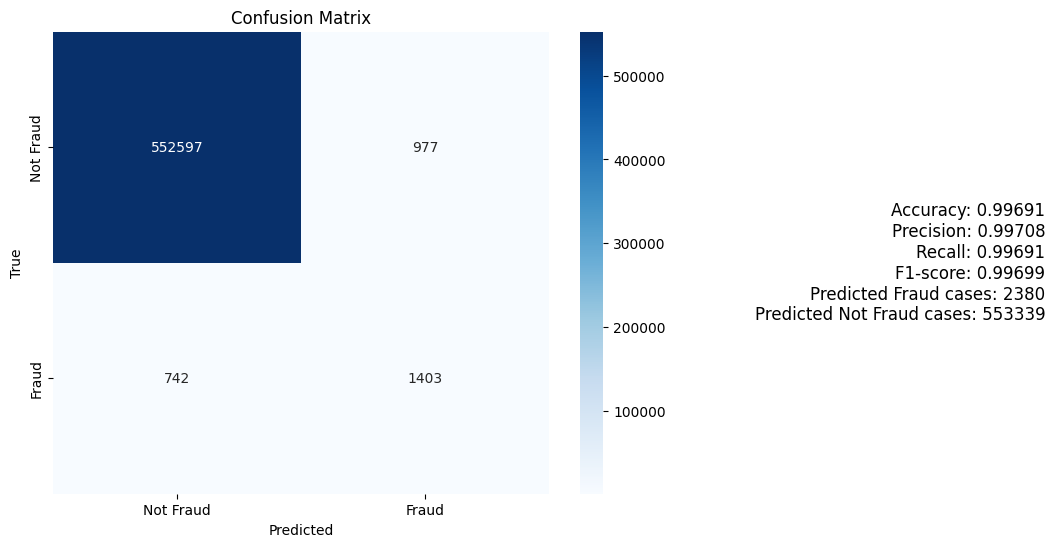

In [ ]:
load_and_evaluate('DT_model.sav', False, X_test, y_test)

In [24]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

save('rf_model.sav', rf_classifier)

print('Saved model successfully')
print('========================')

KeyboardInterrupt: 

In [25]:
load_and_evaluate('rf_model.sav', False, X_test, y_test)

NameError: name 'load_and_evaluate' is not defined